In [3]:
import pandas as pd
import warnings
import datetime as dt
import numpy as np



In [38]:
flat_data = pd.read_csv("../ressources/data/financial_sells_1000000.csv")
flat_data = flat_data.fillna(0).replace('-', np.NaN)
flat_data = flat_data.drop(columns=['Unnamed: 0'])
flat_data.head()

,company_name,company_id,country,sector_name,order_id,product_name,NBI,order_date
0,"Lee, Collins and Herrera",1,Espagne,Electrical industry,1,Issuer Services,30.634977,2016-08-09
1,Hull PLC,2,United Kinkdom,Chemical Industry,2,Forex,-52.820483,2016-11-08
2,"Bell, Miller and Black",3,United State,Energy industry,3,Loans syndication,-1.124973,2016-06-14
3,"Ramirez, Spencer and Tran",4,Italy,Metallurgical industry,4,Equity,98.483580,2016-01-20
4,Tapia and Sons,5,Corse,Automotive,5,Hybrids,134.535646,2019-05-15


In [39]:
flat_data['order_date'] = pd.to_datetime(flat_data['order_date'])

max_timestamp = flat_data['order_date'].max()


rfmTable = flat_data.groupby(['company_name', 'company_id']).agg({
            'order_date': lambda x: (max_timestamp - x.max()).days, # Recency
            'order_id': lambda x: x.count(),      # Frequency
            'NBI': lambda x: x.sum()}) # Monetary Value

rfmTable.rename(columns={'order_date': 'recency', 
                         'order_id': 'frequency', 
                         'NBI': 'monetary_value'},inplace=True)


rfmTable.head(5)

,,recency,frequency,monetary_value
company_name,company_id,,,
Adams Ltd,91,1163,1,1.015989e+02
"Alvarez, Hancock and Bowers",14,0,18198,9.106355e+05
Alvarez-Hernandez,19,0,12127,6.099825e+05
Avila-Garrison,43,0,7301,3.653309e+05
Baldwin Ltd,20,0,36237,1.814658e+06


In [40]:
quantiles = rfmTable.quantile(q=[0.20, 0.4, 0.6, 0.8])
quantiles.head(5)

,recency,frequency,monetary_value
0.2,0.0,31.0,1.723095e+03
0.4,0.0,708.4,3.610245e+04
0.6,1.0,6495.8,3.251255e+05
0.8,28.2,25302.4,1.265047e+06


In [41]:
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1

def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5
    
rfmTable['r_quartile'] = rfmTable['recency'].apply(RScore, args=('recency', quantiles,))
rfmTable['f_quartile'] = rfmTable['frequency'].apply(FMScore, args=('frequency',quantiles,))
rfmTable['m_quartile'] = rfmTable['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))

rfmTable['RFMScore'] = rfmTable['r_quartile'] *100 + rfmTable['f_quartile'] *10 + rfmTable['m_quartile']
rfmTable['total_score'] = rfmTable['r_quartile'] + rfmTable['f_quartile'] + rfmTable['m_quartile']

rfmTable[rfmTable['RFMScore'] == 555].sort_values('monetary_value', ascending=False).head(10)

,,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,total_score
company_name,company_id,,,,,,,,
Ortiz PLC,28,0,39780,1.990795e+06,5,5,5,555,15
Thomas-Martinez,23,0,39395,1.977373e+06,5,5,5,555,15
Davidson Inc,7,0,39443,1.971420e+06,5,5,5,555,15
"Bell, Bryant and Williams",8,0,39536,1.970245e+06,5,5,5,555,15
Gray-Edwards,13,0,39068,1.956454e+06,5,5,5,555,15
Kelly-Harrington,12,0,38476,1.932500e+06,5,5,5,555,15
Smith Inc,21,0,38026,1.895576e+06,5,5,5,555,15
Salinas and Sons,44,0,37250,1.862076e+06,5,5,5,555,15
Baldwin Ltd,20,0,36237,1.814658e+06,5,5,5,555,15


In [43]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}
rfmTable['segment_id'] = rfmTable['r_quartile'].map(str)  + rfmTable['f_quartile'].map(str)
rfmTable['segment_name'] = rfmTable['segment_id'].replace(segt_map, regex=True)
rfmTable.head(5) 

,,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,total_score,segment_id,segment_name
company_name,company_id,,,,,,,,,,
Adams Ltd,91,1163,1,1.015989e+02,1,1,1,111,3,11,hibernating
"Alvarez, Hancock and Bowers",14,0,18198,9.106355e+05,5,4,4,544,13,54,champions
Alvarez-Hernandez,19,0,12127,6.099825e+05,5,4,4,544,13,54,champions
Avila-Garrison,43,0,7301,3.653309e+05,5,4,4,544,13,54,champions
Baldwin Ltd,20,0,36237,1.814658e+06,5,5,5,555,15,55,champions


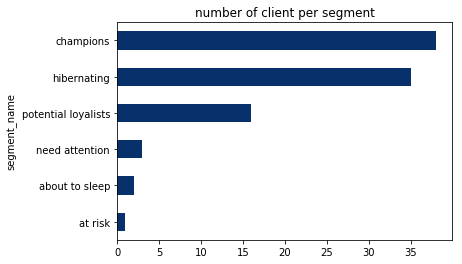

In [44]:
rfmTable.groupby('segment_name')      \
    .agg('segment_id')     \
    .count()         \
    .sort_values() \
    .plot(kind='barh', colormap='Blues_r', title = 'number of client per segment')

In [45]:
rfmTable.to_csv('../ressources/data/3_rfm_segmentation_analysis_result.csv', sep=';')